# Time Series Forecasting using Long Short-Term Memory (LSTM)

***

Long short-term memory (LSTM) is a special type of recurrent neural network that is optimally suited for sequential data. This model takes advantage of time series autocorrelation and is able to remember patterns in the data over the length of the series. This method was first introduced by [Hochreiter & Schmidhuber (1997)](http://www.bioinf.jku.at/publications/older/2604.pdf). <font color=red>The goals of this tutorial are to build a multivariate LSTM neural network using the [Keras](https://keras.io/) deep learning API to forecast sea surface temperature in the North Pacific.</font>

<font color=blue>Datasets:</font> The data consists of 5 time series variables (described below) from the North Pacific at 30n120w, 30n140w, 40n160w, and 50n140w. 

- [NOAA's Optimum Interpolation Sea Surface Temperature](https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html) dataset consists of daily sea surface temperature measurements (ºC) from 1981-09-01 to 2018-06-11. We will be using four time series in the eastern North Pacific.
- [NCEP/NCAR Reanalysis 1](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html) consists of daily atmospheric surface air tempertaure (ºC), relative humidity (%), wind speed (m/s) and sea level pressure (mb) on a global grid from 1948 to present. 
***

<font color=blue>Creator:</font> Hillary Scannell, University of Washington, scanh@uw.edu

<font color=blue>Created:</font> 2018-07-03

***

#### Set Up Python Environment
First we will need to set up our Python environment for deep learning. To do this we will be using Anaconda. If you haven't already, you can download the Windows, OSX, or Linux version of Anaconda [here](https://www.anaconda.com/download/#macos). Make sure you choose Python (>=3.3). After installation, you will want to make sure everything is up-to-date with these commands at the terminal:
```
conda update conda
conda update anaconda
conda install scikit-learn
conda update scikit-learn 
```
To use the Keras API, we also need to install either Theano or TensorFlow backend.
```
conda install theano
conda install -c conda-forge tensorflow
pip install keras
```

Next we will import the Python libraries used in this tutorial. If you have probems importing any of these modules, you may not have them installed on your machine. 

In [6]:
# Import Python Libraries
import numpy as np
import os, time, datetime
from datetime import date
import pandas as pd
from pandas import DataFrame, Series, concat
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.optimizers import SGD, Adam, Adagrad
from keras.layers import Dense, LSTM, Activation, Dropout, TimeDistributed
from marineHeatWaves import detect
import seaborn as sns
import time
from numpy import concatenate

Using TensorFlow backend.
/Users/hscannell/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


#### Import Data
There are four time series of sea surface temperature (SST) contained in seperate netCDF files. The code below extracts the data from the data files using the indexing parameter *f*. Change the path (*fp*) to match the file directory on your machine and choose *f* values from 0 to 3 to change files. 

In [7]:
files = ['30n120w.nc', '30n140w.nc', '40n160w.nc', '50n140w.nc'] 
f = 0 # index to files  <- choose to analyze a different time series by changing f from 0 to 3

lat = files[f][0:2]
lon = files[f][3:6]
print('Location: '+lat+'ºN,'+lon+'ºS')

Location: 30ºN,120ºS


**Sea Surface Temperature (deg-C)**

In [8]:
fp = '/Users/hscannell/Desktop/data/SST_daily_time_series/' # <- change this to your path
data_files = Dataset(fp+'sst_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# SST (deg-C)   
SST = np.squeeze(data_files.variables['sst'][:])

# Time (days since)
f_time = data_files.variables['time'][:] # time is given in days since 1800-01-01 00:00:00
ref = datetime.date(1800, 1, 1).toordinal()
sst_time = ref+f_time # adjust time as days since 0000-01-01 00:00:00

# Dates (yyyy-mm-dd)
sst_dates = [date.fromordinal(tt.astype(int)) for tt in sst_time]
sst_dates = np.array(sst_dates)

# Create a python series
sst = pd.Series(SST)
print(sst.head())
print(sst_dates[0], sst_dates[-1])

lat ('lat',) 1
lon ('lon',) 1
sst ('time', 'lat', 'lon') 13433
time ('time',) 13433
0    18.559999
1    18.629999
2    18.400000
3    18.359999
4    19.049999
dtype: float32
1981-09-01 2018-06-11


**Surface Air Temperature (deg-C)**

In [9]:
fp = '/Users/hscannell/Desktop/data/ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/surface/'
data_files = Dataset(fp+'air_sig995_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 

airt = np.squeeze(data_files.variables['air'][:])
airt = airt-273.15


# Time (days since). Do this once because all atmospheric variables have the same time 
f_time = data_files.variables['time'][:]/24 # hours since 1800-01-01 00:00:0.0
ref = datetime.date(1800, 1, 1).toordinal()
airt_time = ref+f_time 

# Dates (yyyy-mm-dd)
airt_dates = [date.fromordinal(tt.astype(int)) for tt in airt_time]
airt_dates = np.array(airt_dates)

print('SST time: {} to {}'.format(sst_dates[0], sst_dates[-1]))
print('SAT time: {} to {}'.format(airt_dates[0], airt_dates[-1]))

# Index into the atmospheric data where it aligns with the SST data
ind0 = int(np.where(airt_time==sst_time[0])[0])
ind00 = int(np.where(airt_time==sst_time[-1])[0])

atmos_dates = airt_dates[ind0:ind00+1]
airt_time = airt_time[ind0:ind00+1]
airt = airt[ind0:ind00+1]
print('ATMOS time: {} to {}'.format(atmos_dates[0], atmos_dates[-1]))

air ('time', 'lat', 'lon') 25049
lat ('lat',) 1
lon ('lon',) 1
time ('time',) 25049
SST time: 1981-09-01 to 2018-06-11
SAT time: 1950-01-01 to 2018-07-31
ATMOS time: 1981-09-01 to 2018-06-11


**Relative Humidity (%)**

In [10]:
fp = '/Users/hscannell/Desktop/data/NCEP/ftp.cdc.noaa.gov/Datasets/ncep_timeseries/'
data_files = Dataset(fp+'rhum_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# Relative Humidity (%)   
rhum = np.squeeze(data_files.variables['rhum'][:])

# Create a python series
rhum = pd.Series(rhum[ind0:ind00+1])
print(rhum.head())

lat ('lat',) 1
lon ('lon',) 1
rhum ('time', 'lat', 'lon') 13692
time ('time',) 13692
0    78.5
1    77.5
2    85.0
3    87.5
4    87.5
dtype: float32


**Sea Level Pressure (mb)**

In [11]:
fp = '/Users/hscannell/Desktop/data/NCEP/ftp.cdc.noaa.gov/Datasets/ncep_timeseries/'
data_files = Dataset(fp+'slp_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# Sea level pressure (mb)   
slp = np.squeeze(data_files.variables['slp'][:])

# Create a python series
slp = pd.Series(slp[ind0:ind00+1])
print(slp.head())

lat ('lat',) 1
lon ('lon',) 1
slp ('time', 'lat', 'lon') 13692
time ('time',) 13692
0    1012.710022
1    1012.980042
2    1013.520020
3    1014.340027
4    1013.950012
dtype: float32


**Wind Speed (m/s)**

In [12]:
fp = '/Users/hscannell/Desktop/data/NCEP/ftp.cdc.noaa.gov/Datasets/ncep_timeseries/'
data_files = Dataset(fp+'uwnd_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# u-wind (zonal) 
uwnd = np.squeeze(data_files.variables['uwnd'][:])

data_files = Dataset(fp+'vwnd_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# v-wnd (meridional)
vwnd = np.squeeze(data_files.variables['vwnd'][:])

# Create a python series for wind speed
transform_wind = np.sqrt(np.square(uwnd)+np.square(vwnd))
ws = pd.Series(transform_wind[ind0:ind00+1])
print(ws.head()) 

lat ('lat',) 1
lon ('lon',) 1
time ('time',) 13692
uwnd ('time', 'lat', 'lon') 13692
lat ('lat',) 1
lon ('lon',) 1
time ('time',) 13692
vwnd ('time', 'lat', 'lon') 13692
0    10.615127
1    10.266384
2     7.518807
3     4.894738
4     5.169389
dtype: float32


### Plot Time Series

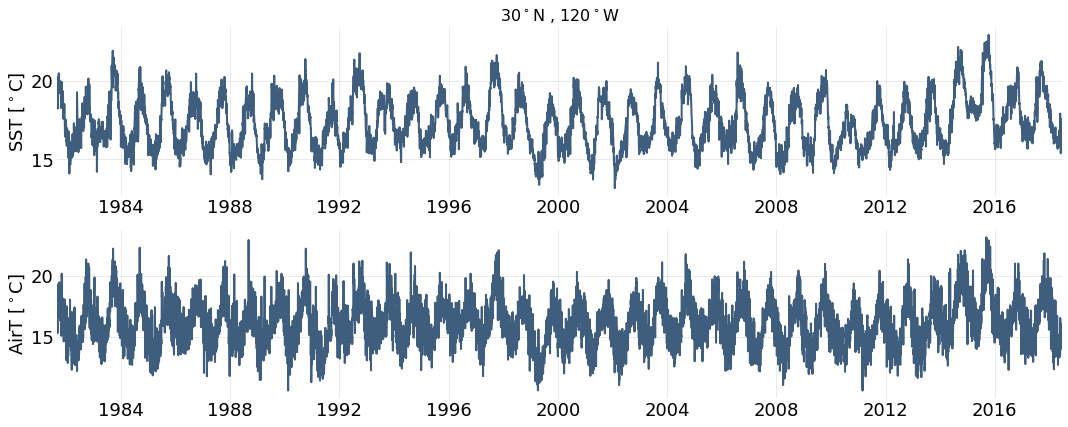

In [13]:
# Plot Time Series
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
plt.figure(figsize=(18, 18))

# SST
ax = plt.subplot(511)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(sst_dates, sst, color="#3F5D7D", linewidth = 2)
plt.ylabel('SST [$^\circ$C]', size=18)
plt.xlim(sst_dates[0], sst_dates[-1])
plt.grid(True, alpha=0.3)
plt.title(lat + '$^\circ$N , ' + lon +'$^\circ$W', fontsize=16)

# Air Temperature
ax = plt.subplot(512)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(atmos_dates, airt, color="#3F5D7D", linewidth = 2)
plt.ylabel('AirT [$^\circ$C]', size=18)
plt.xlim(atmos_dates[0], atmos_dates[-1])
plt.grid(True, alpha=0.3)

# # Relative Humidity
# ax = plt.subplot(513)
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)
# ax.spines["bottom"].set_visible(False)  
# ax.spines["left"].set_visible(False)  
# ax.tick_params(axis=u'both', which=u'both', length=0)
# plt.plot(atmo_dates, rhum, color="#3F5D7D", linewidth = 2)
# plt.ylabel('Rhum [%]', size=18)
# plt.xlim(atmo_dates[0], atmo_dates[-1])
# plt.grid(True, alpha=0.3)

# # Sea Level Pressure
# ax = plt.subplot(514)
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)
# ax.spines["bottom"].set_visible(False)  
# ax.spines["left"].set_visible(False)  
# ax.tick_params(axis=u'both', which=u'both', length=0)
# plt.plot(atmo_dates, slp, color="#3F5D7D", linewidth = 2)
# plt.ylabel('SLP [mb]', size=18)
# plt.xlim(atmo_dates[0], atmo_dates[-1])
# plt.grid(True, alpha=0.3)

# # Wind Speed
# ax = plt.subplot(515)
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)
# ax.spines["bottom"].set_visible(False)  
# ax.spines["left"].set_visible(False)  
# ax.tick_params(axis=u'both', which=u'both', length=0)
# plt.plot(atmo_dates, ws, color="#3F5D7D", linewidth = 2)
# plt.ylabel('WS [m/s]', size=18)
# plt.xlim(atmo_dates[0], atmo_dates[-1])
# plt.grid(True, alpha=0.3)

***
### Exploratory Data Anslysis
Let's look at how these variables are correlated and what meaningful relationships there might be.

         SST       AirT
0  18.559999  15.810028
1  18.629999  16.279999
2  18.400000  16.350006
3  18.359999  15.329987
4  19.049999  16.149994


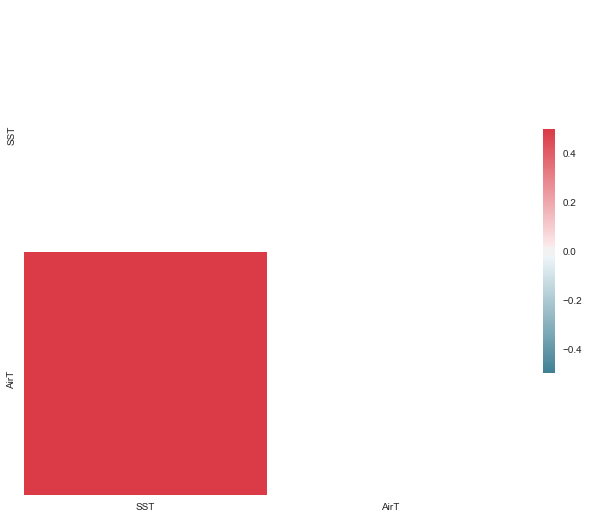

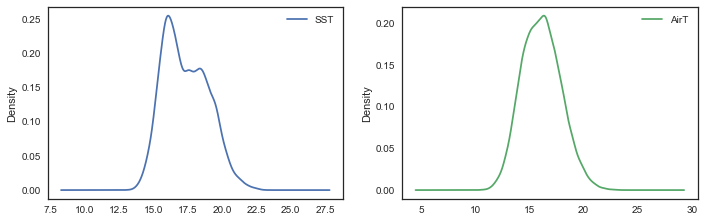

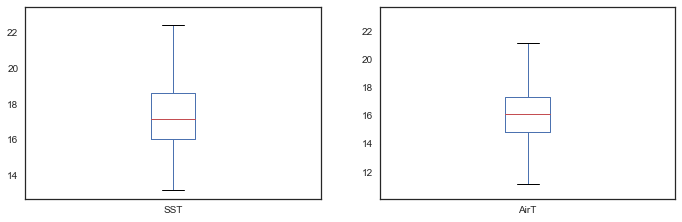

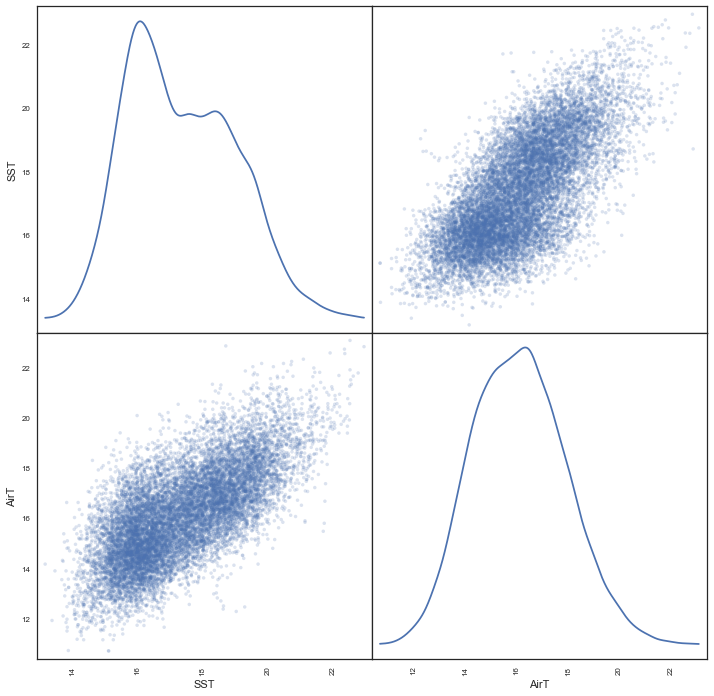

In [14]:
#data = DataFrame(np.transpose(np.array([sst])), columns=['SST'])
data = DataFrame(np.transpose(np.array([sst, airt])), columns=['SST','AirT'])
#data = DataFrame(np.transpose(np.array([sst, airt, rhum, slp, ws])), columns=['SST','AirT','RH','SLP','WS'])

# d = {'SST': sst, 'AirT':airt}
# data = pd.DataFrame(data=d)
print(data.head())

# Correlation matrix
sns.set(style="white")
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool) # Generate a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, vmin=-0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Density
data.plot(kind='density',figsize=(18, 12), subplots=True, layout=(3,3), sharex=False)
plt.show()

# Box and Whiskers
data.plot(kind='box',figsize=(18, 12), subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.show()

# Scatter Matrix 
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

### Missing Values
**Let's loook at our data structure and check for missing values**

In [16]:
# Data = (timesteps, features)
#data = DataFrame(np.transpose(np.array([sst, airt, rhum, slp, ws])), columns=['SST','AirT','RH','SLP','WS'])
#data = DataFrame(np.transpose(np.array([sst, airt, slp])), columns=['SST','AirT','SLP'])

print('Data: ', data.shape)
print (data.head())
print('')

# search for missing values
values = data.values
values = values.astype('float32')
null_data = data[data.isnull().any(axis=1)]
print('Missing values: ', null_data.shape)
print(null_data)
print('')

missing = np.any(np.isnan(values))
finite = np.all(np.isfinite(values)) # determines whether the passed value is a finite number. 
print('Are there missing values in my data?..', missing)
print('Are my values finite?..', finite)

Data:  (13433, 2)
         SST       AirT
0  18.559999  15.810028
1  18.629999  16.279999
2  18.400000  16.350006
3  18.359999  15.329987
4  19.049999  16.149994

Missing values:  (0, 2)
Empty DataFrame
Columns: [SST, AirT]
Index: []

Are there missing values in my data?.. False
Are my values finite?.. True


**Oh no! There are missing values!**

To fill missing values we will linearly interpolate using the pandas series ```interpolate(method='linear', axis=0, limit=5)```. We set the maximum number of consecutive NaNs to fill equal to 5. 

In [17]:
# linearly interpolate missing values column wise
interpval = data.interpolate(method='linear', axis=0, limit=5) 

null_data_ind = null_data.index.tolist()
print('Interpolated Values:')
print(interpval.iloc[null_data_ind])

Interpolated Values:
Empty DataFrame
Columns: [SST, AirT]
Index: []


Let's update the data with the interpolated values and create an array for time that coincides with it. We will create a ```time``` array with days since 0000-01-01 00:00:00 and a ```dates``` array for oridnal time.

In [18]:
# Update data with interpolated values
data = interpval
dates = atmos_dates

***
# 1. Data Prep
1. Normalize features
2. Create lagged series
3. Divide data into a training and test set


### Normalize features

In [19]:
values = data.values
values = values.astype('float32') # ensure all data is float
print(values.shape)

(13433, 2)


### Create lagged supervised series

In [20]:
n_features = data.shape[1]       # SST, airT, RH, SLP, WS
steps = 30                       # forecast sequence
lag = 30 #steps*7                      # input sequence (length of samples will be reduced by the # of lags)
print(n_features)

2


In [42]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, dropnan=True): # 
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# frame as supervised learning
reframed = series_to_supervised(values, lag, steps)

print(reframed.head())
print('Size of supervised series =', reframed.shape, ' = [#samlples, (n_features*lags + n_features*steps)]')
values = reframed.values
dates = dates[lag:] # length of samples was reduced by #lag

    var1(t-30)  var2(t-30)  var1(t-29)  var2(t-29)  var1(t-28)  var2(t-28)  \
30   18.559999   15.810028   18.629999   16.279999   18.400000   16.350006   
31   18.629999   16.279999   18.400000   16.350006   18.359999   15.329987   
32   18.400000   16.350006   18.359999   15.329987   19.049999   16.149994   
33   18.359999   15.329987   19.049999   16.149994   19.180000   15.430023   
34   19.049999   16.149994   19.180000   15.430023   19.230000   16.149994   

    var1(t-27)  var2(t-27)  var1(t-26)  var2(t-26)     ...      var1(t+25)  \
30   18.359999   15.329987   19.049999   16.149994     ...       19.260000   
31   19.049999   16.149994   19.180000   15.430023     ...       18.699999   
32   19.180000   15.430023   19.230000   16.149994     ...       18.619999   
33   19.230000   16.149994   18.389999   17.480011     ...       18.609999   
34   18.389999   17.480011   18.379999   18.209991     ...       18.549999   

    var2(t+25)  var1(t+26)  var2(t+26)  var1(t+27)  var2(t+27)

 batch size = 32 
 training data length = 10048

 batch size = 32 
 validation data length = 2496

 batch size = 32 
 test data length = 704



### Split data into training and testing sets

Stateful LSTMs must have a training set size that is divisible by the batch size. 

In [57]:
# ## split into input and outputs
#values = data.values
#values = values.astype('float32') # ensure all data is float
n_obs = lag*n_features
print('total number of n_obs (lags x features) =', n_obs)
print('dates size =', dates.shape)
print('')



# Split data
ntest = 720
train = values[:-ntest, :] # values[:train_length, :]  
test = values[-ntest:, :]
val20 = int(np.ceil(train.shape[0]*.2)) # 25 percent of data
val = train[-val20:-lag]
train = train[:-val20-lag,:]
scaler = scaler.fit(train)

# Transform data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)
train = scaler.transform(train)
val = scaler.transform(val)
test = scaler.transform(test)
                       
xtrain, ytrain = train[:, :n_obs], train[:, -n_features*steps:] # Target value is the temperature at day[steps]
xtest, ytest = test[:, :n_obs], test[:, -n_features*steps:] 
Xval = val[:, :n_obs]
yval = val[:, -n_features*steps:]
print('size validation set: Xval={}, yval={}'.format(Xval.shape, yval.shape))
print('size training set: Xtrain={}, ytrain={}'.format(xtrain.shape, ytrain.shape))
print('size testing set: Xtest={}, ytest={}'.format(xtest.shape, ytest.shape))



# reshape input to be 3D [samples, timesteps, features]
Xtrain = xtrain.reshape((xtrain.shape[0], lag, n_features))
Xtest = xtest.reshape((xtest.shape[0], lag, n_features))
ytrain = ytrain.reshape((ytrain.shape[0], steps, n_features)) 
ytest = ytest.reshape((ytest.shape[0], steps, n_features)) 
Xval = Xval.reshape((Xval.shape[0], steps, n_features))
yval = yval.reshape((yval.shape[0], steps, n_features))

print('\n training targets = {}\n test targets = {}'.format(ytrain.shape, ytest.shape))
print('\n**[samles, input sequence, features]**')
print('training set = {}'.format(Xtrain.shape))
print('test set = {}'.format(Xtest.shape))
print('Xval = {}'.format(Xval.shape))
print('yval = {}'.format(yval.shape))



batch_size = 32

def get_train_length(dataset, batch_size, test_percent):
    # subtract test_percent to be excluded from training, reserved for test set
    length = len(dataset)
    #length *= 1-test_percent
    train_length_values = []
    for x in range(int(length)-100, int(length)):
        mod = x%batch_size
        if (mod == 0):
            train_length_values.append(x)
    return (max(train_length_values))

# Training Length
train_length = get_train_length(Xtrain, batch_size, 0.1) # find the training length that is divisible by our batch size
print(' batch size = {} \n training data length = {}\n'.format(batch_size, train_length))
X_train = Xtrain[:train_length]
y_train = ytrain[:train_length]
print(X_train.shape, y_train.shape)


# Validation Length
val_length = get_train_length(Xval, batch_size, 0.1) # find the training length that is divisible by our batch size
print(' batch size = {} \n validation data length = {}\n'.format(batch_size, val_length))
X_val = Xval[:val_length]
y_val = yval[:val_length]
print(X_val.shape, y_val.shape)


# Test Length
test_length = get_train_length(Xtest, batch_size, 0.1) 
print(' batch size = {} \n validation data length = {}\n'.format(batch_size, test_length))
X_test = Xtest[:test_length]
y_test = ytest[:test_length]

print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


total number of n_obs (lags x features) = 60
dates size = (13343,)

size validation set: Xval=(2501, 60), yval=(2501, 60)
size training set: Xtrain=(10093, 60), ytrain=(10093, 60)
size testing set: Xtest=(720, 60), ytest=(720, 60)

 training targets = (10093, 30, 2)
 test targets = (720, 30, 2)

**[samles, input sequence, features]**
training set = (10093, 30, 2)
test set = (720, 30, 2)
Xval = (2501, 30, 2)
yval = (2501, 30, 2)
 batch size = 32 
 training data length = 10080

(10080, 30, 2) (10080, 30, 2)
 batch size = 32 
 validation data length = 2496

(2496, 30, 2) (2496, 30, 2)
 batch size = 32 
 validation data length = 704

(704, 30, 2) (704, 30, 2)
(10080, 30, 2) (10080, 30, 2)
(2496, 30, 2) (2496, 30, 2)


***
## 2. LSTM Model


### Define  LSTM

- TimeDistributed is a "layer wrapper" that allows us to apply a layer to every temporal slice of an input.

https://keras.io/layers/wrappers/#timedistributed

https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed

#### <font color=red>What loss function? </font>[(keras loss functions)](https://keras.io/losses/)
- Mean Squared Error ('mean_squared_error')
- Mean Absolute Error ('mae')

#### <font color=red>What optimizer?</font> [(keras optimizers)](https://keras.io/optimizers/)
- Stochastic Gradient Descent (sgd), has parameters: learning rate, learning decay factor, and momentum parameter. [keras documentation](https://keras.io/optimizers/#sgd)
- Adam ('adam'), [keras documentation](https://keras.io/optimizers/#adam), [[Kingma and Ba, 2017]](https://arxiv.org/abs/1412.6980v8)

#### <font color=red>What activation?</font>  [(keras activation)](https://keras.io/activations/)
* tanh
* softmax
* softplus
* relu
* sigmoid
* hard_sigmoid
* linear


In [58]:
#Stochastic Gradient Descent
sgd = SGD(lr=0.01,
         decay=0,    # learning rate decay over each update
         momentum=0)  # updates momentum
# Adam
adam = Adam(lr=0.01, 
            beta_1=0.9, 
            beta_2=0.999, 
            epsilon=1e-08, 
            decay=0.0)

# Adagrad
adagrad = Adagrad(lr=0.1, 
                  epsilon=1e-08, 
                  decay=0.0)

In [59]:
# Design network
LSTM1_neurons = 12
#output_neurons = 4 #fully connected layer
epochs = 10 #number of full passes over all the training data

# Build model
model = Sequential()

model.add(LSTM(LSTM1_neurons, 
               batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
               input_shape=(X_train.shape[0], X_train.shape[2]), 
               return_sequences=True, 
               stateful=True,
               activation='tanh'))

model.add(TimeDistributed(Dense(n_features)))

model.compile(loss='mean_squared_error',
              optimizer=adagrad,
              metrics=['mse'])
model.summary()

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_val, y_val),
                    verbose=1, 
                    shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (32, 30, 12)              720       
_________________________________________________________________
time_distributed_2 (TimeDist (32, 30, 2)               26        
Total params: 746
Trainable params: 746
Non-trainable params: 0
_________________________________________________________________
Train on 10080 samples, validate on 2496 samples
Epoch 1/10
10080/10080 [==============================] - 7s 716us/step - loss: 0.0546 - mean_squared_error: 0.0546 - val_loss: 0.0630 - val_mean_squared_error: 0.0630
Epoch 2/10
10080/10080 [==============================] - 7s 647us/step - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0619 - val_mean_squared_error: 0.0619
Epoch 3/10
10080/10080 [==============================] - 7s 654us/step - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0573 - val_mean_squared_e

In [62]:
# Evaluate model
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Score: {}'.format(score))
    
# Make a prediction
yhat = model.predict(X_test) # predict on new features
print('yhat=', yhat.shape)
yhat = yhat.reshape(yhat.shape[0], yhat.shape[1]*n_features)

# Invert scaling for forecast
X_testt = X_test.reshape((X_test.shape[0], lag*n_features))
print(yhat.shape, X_testt.shape)
inv_yhat = concatenate((yhat, X_testt), axis=1)
print(yhat.shape, X_testt.shape, inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:lag*n_features:2]
print(inv_yhat.shape)

# Invert scaling for actual
y_testy = y_test.reshape((y_test.shape[0], lag*n_features))
inv_y = concatenate((y_testy, X_testt), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,lag*n_features::2]
print(inv_y.shape)

# Calculate RMSE
rmse = []
mse = []
for i in np.arange(0,inv_y.shape[0]):
    rmse.append(np.sqrt(mean_squared_error(inv_y[i,:], inv_yhat[i,:])))
    mse.append(mean_squared_error(inv_y, inv_yhat))
print('RMSE = ', np.mean(rmse))

704/704 [==============================] - 0s 224us/step
Score: [0.0411332891407338, 0.04113329007205638]
yhat= (704, 30, 2)
(704, 60) (704, 60)
(704, 60) (704, 60) (704, 120)


ValueError: operands could not be broadcast together with shapes (704,60) (120,) (704,60) 

(0, 734)

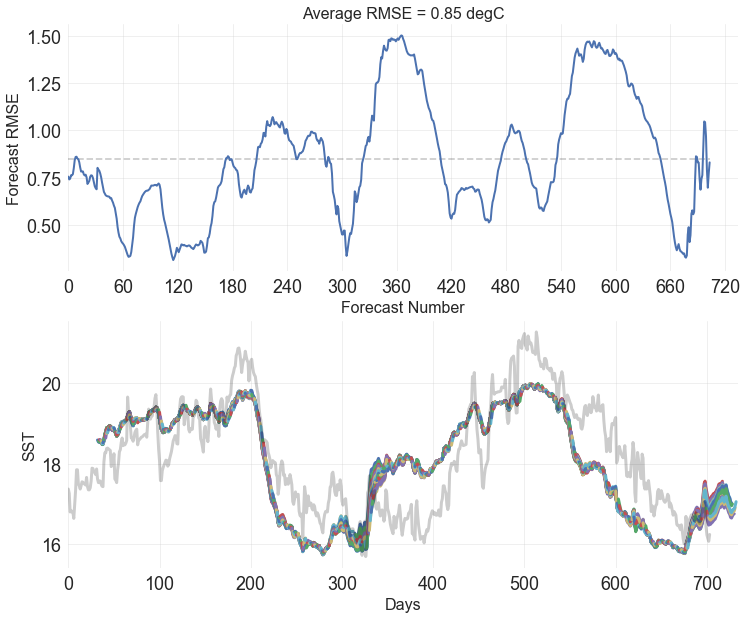

In [61]:
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

plt.figure(figsize=(12,10)); ax = plt.subplot(211) 
plt.plot(np.arange(0,len(rmse)),np.tile(np.mean(rmse),len(rmse)), '--', color='black', alpha=0.2)
plt.plot(rmse, linewidth=2)
plt.xlabel('Forecast Number', fontsize=16)
plt.ylabel('Forecast RMSE', fontsize=16)
plt.title('Average RMSE = %.2f degC' % np.average(rmse), fontsize=16)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.xlim((0, len(rmse)+lag)) 
plt.xticks(np.arange(0, len(rmse)+lag, step=60));

obs = inv_y[:,0]
ax = plt.subplot(212) 
for i in np.arange(lag+2,inv_y.shape[0],1):
    plt.plot(np.arange(i,i+lag), inv_yhat[i,:], linewidth=3)
plt.plot(np.arange(0,len(rmse)), obs, color='black', alpha=0.2, linewidth=3)
plt.xlabel('Days', fontsize=16)
plt.ylabel('SST', fontsize=16)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), fontsize=16,frameon=False)
plt.xlim((0, len(rmse)+lag)) 
#plt.xticks(np.arange(0, len(rmse)+lag, step=60));

***
## 3. Model evaluation

### Run model diagnostics

In [ ]:
#print(history.history.keys())
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

# Summarize history for loss
# If validation drops below training, tge model may be overfitting the training data
plt.figure(figsize=(12,6)); ax = plt.subplot(111) 
plt.plot(history.history['loss'], 'o-', color="xkcd:ocean blue", linewidth=3, label='training')
plt.plot(history.history['val_loss'], 'o-', color="xkcd:red orange", linewidth=3, label='validation')
plt.ylabel('Loss (MSE)', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(loc='upper right', fontsize=16, frameon=False)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)


# # Plot prediction
# err_up = inv_yhat+rmse
# err_lw = inv_yhat-rmse
# plt.figure(figsize=(12,6)); ax = plt.subplot(111) 
# print(err_up.shape)

plt.plot(dates[-ntest:], inv_y, color="gray", label='test data', linewidth=3)
plt.plot(dates[-ntest:-steps], inv_yhat[steps:], label='prediction', color="red", linewidth=3)
plt.fill_between(dates[-ntest:-steps], err_up[steps:], err_lw[steps:], facecolor='red', interpolate=True, alpha = 0.1, label="error (+/-%0.2fºC)" % rmse)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), fontsize=16,frameon=False)
plt.ylabel('SST [deg-C]', fontsize=16)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)

# Adjusted
plt.figure(figsize=(12,6)); ax = plt.subplot(111) 
plt.plot(dates[-ntest:], inv_y, color="gray", label='test data', linewidth=3)
plt.plot(dates[-ntest:], inv_yhat, label='prediction', color="red", linewidth=3)
plt.fill_between(dates[-ntest:], err_up, err_lw, facecolor='red', interpolate=True, alpha = 0.1, label="error (+/-%0.2fºC)" % rmse)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), fontsize=16,frameon=False)
plt.ylabel('SST [deg-C]', fontsize=16)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)
#plt.gcf().autofmt_xdate()


## 4. Marine heatwave prediction 
 Compute SST climatology and marine heatwave thresholds
- Use the [*marineHeatWave*](https://github.com/ecjoliver/marineHeatWaves) module by Eric Oliver to calculate the daily seasonal SST climatology and MHW thresholds


In [ ]:
sst = data['SST']
sst = np.array(sst)

mhw, clim = detect(time, sst, climatologyPeriod=[1988, 2017], 
       pctile=90, windowHalfWidth=5, smoothPercentile=True, 
       smoothPercentileWidth=31, minDuration=5, 
       joinAcrossGaps=True, maxGap=2, maxPadLength=False, 
       coldSpells=False, alternateClimatology=False)


sst_clim = clim['seas'] # seasonal climatology computed between 1988-2017
mhw_thres = clim['thresh'] # marine heatwave threshold computed as the 90th percentile from the seasonal climatology

#### Plot predictions on top of climatology and observations

In [ ]:
# Make figure, define axis, set default font size
plt.figure(figsize=(18,8))
ax = plt.subplot(111)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

# Plot climatology, SST observations, prediction and overlay shading for model error and marine heatwave thresholds
plt.plot(time[-(ntest):], sst_clim[-(ntest):], linewidth = 3, color="black", label="climatology")
plt.plot(time[-ntest:-steps], inv_yhat[steps:], label='LSTM prediction', linewidth = 3, color='red') 
plt.plot(dates[-(ntest):], data['SST'].values[-(ntest):], color="black", alpha=0.6,  linewidth=3, label='observations')
y1 = sst_clim[-(ntest):]
y2 = mhw_thres[-(ntest):]
y3 = data['SST'].values[-(ntest):]
dely = y1-(y2-y1) # ad hoc way to find 10th percentile
plt.fill_between(sst_dates[-ntest:], dely, y2, facecolor='black', interpolate=True, alpha=0.1, label="10-90$^{th}$ percentile")
plt.fill_between(dates[-ntest:-steps], err_up[steps:], err_lw[steps:], facecolor='red', interpolate=True, alpha = 0.1, label="model error (+/-%0.2fºC)" % rmse)
plt.fill_between(dates[-ntest:], y2, y3, where=y2 <= y3,  facecolor='red',interpolate=True, alpha = .5)
plt.fill_between(dates[-ntest:], y3, dely, where=y3 <= dely,  facecolor='blue',alpha = 0.5)

# Make viz pretty
plt.legend(loc="lower left", fontsize=14, frameon=False, ncol=5)
plt.title(lat+'$^\circ$N '+lon+'$^\circ$W,  RMSE = %.3f$^\circ$C' % rmse, fontsize=18)
plt.ylabel('SST [ºC]', size=16)
plt.grid(True, alpha=0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), fontsize=16);

***
**Coding Inspiration:** The following code was created by adapting methods from the following blogs and websites:
- https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
- https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/

Marine Heatwave Dectection Module ([Hobday et al., 2016](https://www.sciencedirect.com/science/article/pii/S0079661116000057))
- https://github.com/ecjoliver/marineHeatWaves